In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class AirlineMarketAnalysis:
    def __init__(self, data_path):
        """Initialize the analysis with airline dataset"""
        self.data = pd.read_csv(data_path)
        self.clean_data()

    def clean_data(self):
        """Clean and prepare the dataset"""
        print("🧹 Cleaning dataset...")

        # Remove any unnamed columns
        self.data = self.data.loc[:, ~self.data.columns.str.contains('^Unnamed')]

        # Strip whitespace from column names
        self.data.columns = self.data.columns.str.strip()

        # Convert price to numeric, handling any string values
        self.data['price'] = pd.to_numeric(self.data['price'], errors='coerce')

        # Convert days_left to numeric
        self.data['days_left'] = pd.to_numeric(self.data['days_left'], errors='coerce')

        # Convert 'stops' to numeric
        stop_mapping = {'zero': 0, 'one': 1, 'two_or_more': 2}
        self.data['stops'] = self.data['stops'].str.replace(' stops', '').map(stop_mapping)
        self.data['stops'] = pd.to_numeric(self.data['stops'], errors='coerce')


        # Create route column for easier analysis
        self.data['route'] = self.data['source_city'].astype(str) + ' → ' + self.data['destination_city'].astype(str)

        # Remove rows with missing essential data
        essential_cols = ['airline', 'price', 'route', 'stops']
        self.data = self.data.dropna(subset=essential_cols)

        print(f"✅ Data cleaned. Shape: {self.data.shape}")

    def basic_overview(self):
        """Generate comprehensive dataset overview"""
        print("\n" + "="*60)
        print("📊 AIRLINE MARKET DATASET OVERVIEW")
        print("="*60)

        # Basic statistics
        print(f"Dataset Size: {self.data.shape[0]:,} flights, {self.data.shape[1]} variables")
        print(f"Date Range: {self.data['days_left'].min()}-{self.data['days_left'].max()} days ahead")
        print(f"Price Range: ${self.data['price'].min():.0f} - ${self.data['price'].max():,.0f}")

        # Market structure
        print(f"\n🏢 Market Structure:")
        print(f"   • {self.data['airline'].nunique()} airlines")
        print(f"   • {self.data['route'].nunique()} unique routes")
        print(f"   • {self.data['class'].nunique()} service classes")
        print(f"   • {self.data['source_city'].nunique()} origin cities")
        print(f"   • {self.data['destination_city'].nunique()} destination cities")

        # Missing data analysis
        print(f"\n🔍 Data Quality:")
        missing_pct = (self.data.isnull().sum() / len(self.data)) * 100
        for col in missing_pct[missing_pct > 0].index:
            print(f"   • {col}: {missing_pct[col]:.1f}% missing")

        return self.data.describe()

    def market_concentration_analysis(self):
        """Analyze market concentration and competitive dynamics"""
        print("\n" + "="*60)
        print("🏆 MARKET CONCENTRATION ANALYSIS")
        print("="*60)

        # Overall airline market share
        airline_share = (self.data['airline'].value_counts() / len(self.data) * 100).round(2)
        print("\n📈 Overall Market Share:")
        for airline, share in airline_share.head(10).items():
            print(f"   {airline}: {share}%")

        # Calculate Herfindahl-Hirschman Index (HHI)
        hhi = sum(airline_share ** 2)
        print(f"\n📊 Market Concentration (HHI): {hhi:.0f}")
        if hhi > 2500:
            print("   Status: Highly concentrated market")
        elif hhi > 1500:
            print("   Status: Moderately concentrated market")
        else:
            print("   Status: Competitive market")

        # Route-level concentration
        route_concentration = {}
        for route in self.data['route'].value_counts().head(20).index:
            route_data = self.data[self.data['route'] == route]
            route_airlines = route_data['airline'].value_counts()
            route_hhi = sum((route_airlines / len(route_data) * 100) ** 2)
            route_concentration[route] = {
                'flights': len(route_data),
                'airlines': len(route_airlines),
                'hhi': route_hhi,
                'dominant_airline': route_airlines.index[0],
                'dominant_share': route_airlines.iloc[0] / len(route_data) * 100
            }

        # Display most concentrated routes
        print(f"\n🛣️ Most Concentrated Routes (Top 10):")
        sorted_routes = sorted(route_concentration.items(),
                             key=lambda x: x[1]['hhi'], reverse=True)[:10]

        for route, metrics in sorted_routes:
            print(f"   {route}")
            print(f"     Dominant: {metrics['dominant_airline']} ({metrics['dominant_share']:.1f}%)")
            print(f"     Airlines: {metrics['airlines']}, HHI: {metrics['hhi']:.0f}")

        return airline_share, route_concentration

    def pricing_strategy_analysis(self):
        """Analyze pricing strategies across segments"""
        print("\n" + "="*60)
        print("💰 PRICING STRATEGY ANALYSIS")
        print("="*60)

        # Price by airline
        airline_pricing = self.data.groupby('airline')['price'].agg([
            'count', 'mean', 'median', 'std'
        ]).round(2)
        airline_pricing.columns = ['Flights', 'Avg_Price', 'Median_Price', 'Price_StdDev']
        airline_pricing = airline_pricing.sort_values('Avg_Price', ascending=False)

        print("\n💸 Airline Pricing Tiers (Top 10):")
        for airline, row in airline_pricing.head(10).iterrows():
            tier = "Premium" if row['Avg_Price'] > airline_pricing['Avg_Price'].quantile(0.75) else \
                   "Budget" if row['Avg_Price'] < airline_pricing['Avg_Price'].quantile(0.25) else "Mid-tier"
            print(f"   {airline}: ${row['Avg_Price']:.0f} ({tier})")

        # Price by class
        class_pricing = self.data.groupby('class')['price'].agg(['mean', 'count']).round(2)
        class_pricing.columns = ['Avg_Price', 'Flights']
        print(f"\n✈️ Price by Service Class:")
        for class_name, row in class_pricing.sort_values('Avg_Price', ascending=False).iterrows():
            print(f"   {class_name}: ${row['Avg_Price']:.0f} ({row['Flights']} flights)")

        # Price by stops
        stops_pricing = self.data.groupby('stops')['price'].agg(['mean', 'count']).round(2)
        print(f"\n🔄 Price by Number of Stops:")
        for stops, row in stops_pricing.iterrows():
            print(f"   {stops} stops: ${row['mean']:.0f} ({row['count']} flights)")

        return airline_pricing, class_pricing, stops_pricing

    def route_opportunity_analysis(self):
        """Identify route opportunities and market gaps"""
        print("\n" + "="*60)
        print("🎯 ROUTE OPPORTUNITY ANALYSIS")
        print("="*60)

        # High-value routes (price per mile proxy)
        route_metrics = self.data.groupby('route').agg({
            'price': ['mean', 'count', 'std'],
            'airline': 'nunique',
            'stops': 'mean'
        }).round(2)

        route_metrics.columns = ['Avg_Price', 'Flight_Count', 'Price_StdDev', 'Num_Airlines', 'Avg_Stops']
        route_metrics['Price_Premium'] = (route_metrics['Avg_Price'] - self.data['price'].mean()) / self.data['price'].std()

        # High-value, low-competition routes (opportunities)
        opportunities = route_metrics[
            (route_metrics['Price_Premium'] > 1) &
            (route_metrics['Num_Airlines'] <= 2) &
            (route_metrics['Flight_Count'] >= 10)
        ].sort_values('Price_Premium', ascending=False)

        print(f"\n🚀 Market Opportunities (High price, low competition):")
        for route, metrics in opportunities.head(10).iterrows():
            print(f"   {route}")
            print(f"     Price: ${metrics['Avg_Price']:.0f} (+{metrics['Price_Premium']:.1f}σ)")
            print(f"     Airlines: {metrics['Num_Airlines']}, Flights: {metrics['Flight_Count']}")

        # Underserved routes (high demand, many stops)
        underserved = route_metrics[
            (route_metrics['Flight_Count'] >= 20) &
            (route_metrics['Avg_Stops'] >= 1)
        ].sort_values(['Flight_Count', 'Avg_Stops'], ascending=[False, False])

        print(f"\n🔄 Potentially Underserved Routes (Many connections needed):")
        for route, metrics in underserved.head(10).iterrows():
            print(f"   {route}")
            print(f"     Demand: {metrics['Flight_Count']} flights, Avg stops: {metrics['Avg_Stops']:.1f}")
            print(f"     Airlines serving: {metrics['Num_Airlines']}")

        return opportunities, underserved

    def customer_segmentation_analysis(self):
        """Analyze customer segments and behavior patterns"""
        print("\n" + "="*60)
        print("👥 CUSTOMER SEGMENTATION ANALYSIS")
        print("="*60)

        # Booking behavior by advance purchase
        self.data['booking_window'] = pd.cut(self.data['days_left'],
                                           bins=[0, 7, 30, 90, float('inf')],
                                           labels=['Last_minute', 'Short_term', 'Medium_term', 'Long_term'])

        booking_behavior = self.data.groupby('booking_window').agg({
            'price': ['mean', 'count'],
            'class': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown',
            'stops': 'mean'
        }).round(2)

        print(f"\n📅 Booking Behavior Analysis:")
        for window, metrics in booking_behavior.iterrows():
            avg_price = metrics[('price', 'mean')]
            count = metrics[('price', 'count')]
            popular_class = metrics[('class', '<lambda>')]
            avg_stops = metrics[('stops', 'mean')]
            print(f"   {window} ({count} bookings):")
            print(f"     Avg price: ${avg_price:.0f}, Popular class: {popular_class}")
            print(f"     Avg stops: {avg_stops:.1f}")

        # Price sensitivity by segment
        segment_analysis = self.data.groupby(['class', 'booking_window'])['price'].agg(['mean', 'count']).round(2)

        return booking_behavior, segment_analysis

    def create_visualizations(self):
        """Create comprehensive visualization suite"""
        print("\n" + "="*60)
        print("📊 GENERATING MARKET VISUALIZATIONS")
        print("="*60)

        fig = plt.figure(figsize=(20, 15))

        # 1. Market Share
        plt.subplot(2, 3, 1)
        airline_counts = self.data['airline'].value_counts().head(10)
        plt.pie(airline_counts.values, labels=airline_counts.index, autopct='%1.1f%%')
        plt.title('Market Share by Airline', fontsize=14, fontweight='bold')

        # 2. Price Distribution by Class
        plt.subplot(2, 3, 2)
        sns.boxplot(data=self.data, x='class', y='price')
        plt.title('Price Distribution by Class', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)

        # 3. Price vs Days Left
        plt.subplot(2, 3, 3)
        plt.scatter(self.data['days_left'], self.data['price'], alpha=0.5)
        plt.xlabel('Days Until Departure')
        plt.ylabel('Price ($)')
        plt.title('Price vs Booking Window', fontsize=14, fontweight='bold')

        # 4. Average Price by Number of Stops
        plt.subplot(2, 3, 4)
        stops_avg = self.data.groupby('stops')['price'].mean()
        stops_avg.plot(kind='bar')
        plt.title('Average Price by Stops', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Stops')
        plt.ylabel('Average Price ($)')

        # 5. Route Volume Distribution
        plt.subplot(2, 3, 5)
        route_counts = self.data['route'].value_counts().head(15)
        plt.barh(range(len(route_counts)), route_counts.values)
        plt.yticks(range(len(route_counts)), route_counts.index)
        plt.title('Top 15 Routes by Volume', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Flights')

        # 6. Price Heatmap by Airline and Class
        plt.subplot(2, 3, 6)
        pivot_table = self.data.pivot_table(values='price', index='airline', columns='class', aggfunc='mean')
        sns.heatmap(pivot_table.head(10), annot=True, fmt='.0f', cmap='YlOrRd')
        plt.title('Price Heatmap: Airlines vs Classes', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.savefig('airline_market_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ Visualizations saved as 'airline_market_analysis.png'")

    def generate_strategic_insights(self):
        """Generate actionable business insights"""
        print("\n" + "="*60)
        print("🎯 STRATEGIC MARKET INSIGHTS")
        print("="*60)

        insights = []

        # Market concentration insight
        airline_share = self.data['airline'].value_counts(normalize=True) * 100
        top3_share = airline_share.head(3).sum()
        insights.append(f"Market Concentration: Top 3 airlines control {top3_share:.1f}% of flights")

        # Price premium opportunities
        class_premiums = self.data.groupby('class')['price'].mean().sort_values(ascending=False)
        if len(class_premiums) > 1:
            premium_opportunity = ((class_premiums.iloc[0] - class_premiums.iloc[-1]) / class_premiums.iloc[-1]) * 100
            insights.append(f"Premium Pricing: {class_premiums.index[0]} commands {premium_opportunity:.1f}% premium over {class_premiums.index[-1]}")

        # Route efficiency insight
        direct_vs_stops = self.data.groupby('stops')['price'].mean()
        if len(direct_vs_stops) > 1:
            connection_penalty = ((direct_vs_stops.iloc[-1] - direct_vs_stops.iloc[0]) / direct_vs_stops.iloc[0]) * 100
            insights.append(f"Connection Premium: Flights with stops cost {abs(connection_penalty):.1f}% {'more' if connection_penalty > 0 else 'less'}")

        # Booking window insight
        booking_corr = self.data['days_left'].corr(self.data['price'])
        trend = "increase" if booking_corr > 0 else "decrease"
        insights.append(f"Booking Timing: Prices tend to {trend} as departure approaches (correlation: {booking_corr:.2f})")

        print("\n💡 Key Strategic Insights:")
        for i, insight in enumerate(insights, 1):
            print(f"   {i}. {insight}")

        return insights

    def run_full_analysis(self):
        """Execute complete market analysis"""
        print("🚀 Starting Comprehensive Airline Market Analysis...")

        # Run all analyses
        overview = self.basic_overview()
        airline_share, route_conc = self.market_concentration_analysis()
        pricing_analysis = self.pricing_strategy_analysis()
        opportunities, underserved = self.route_opportunity_analysis()
        segmentation = self.customer_segmentation_analysis()

        # Generate visualizations
        self.create_visualizations()

        # Strategic insights
        insights = self.generate_strategic_insights()

        print("\n" + "="*60)
        print("✅ ANALYSIS COMPLETE!")
        print("="*60)
        print("📁 Files generated:")
        print("   • airline_market_analysis.png (comprehensive charts)")
        print("\n🎯 Next Steps for Portfolio:")
        print("   1. Deep dive into identified opportunities")
        print("   2. Develop competitive positioning strategies")
        print("   3. Create route optimization recommendations")
        print("   4. Build predictive pricing models")

        return {
            'overview': overview,
            'market_concentration': (airline_share, route_conc),
            'pricing_analysis': pricing_analysis,
            'opportunities': opportunities,
            'underserved_routes': underserved,
            'segmentation': segmentation,
            'insights': insights
        }

# Usage Example
if __name__ == "__main__":
    # Initialize analysis
    analyzer_example = AirlineMarketAnalysis('/content/airlines_flights_data.csv')

    # Run complete analysis
    # results = analyzer_example.run_full_analysis()

    print("📝 To use this analysis:")
    print("1. Replace 'your_airline_dataset.csv' with your file path")
    print("2. Run: python airline_analysis.py")
    print("3. Review generated insights and visualizations")
    print("\n🎯 This analysis will provide:")
    print("   • Market concentration metrics")
    print("   • Competitive landscape mapping")
    print("   • Route opportunity identification")
    print("   • Customer segmentation insights")
    print("   • Strategic recommendations")

🧹 Cleaning dataset...
✅ Data cleaned. Shape: (300153, 13)
📝 To use this analysis:
1. Replace 'your_airline_dataset.csv' with your file path
2. Run: python airline_analysis.py
3. Review generated insights and visualizations

🎯 This analysis will provide:
   • Market concentration metrics
   • Competitive landscape mapping
   • Route opportunity identification
   • Customer segmentation insights
   • Strategic recommendations


🧹 Cleaning dataset...
✅ Data cleaned. Shape: (300153, 13)
🚀 Starting Comprehensive Airline Market Analysis...

📊 AIRLINE MARKET DATASET OVERVIEW
Dataset Size: 300,153 flights, 13 variables
Date Range: 1-49 days ahead
Price Range: $1105 - $123,071

🏢 Market Structure:
   • 6 airlines
   • 30 unique routes
   • 2 service classes
   • 6 origin cities
   • 6 destination cities

🔍 Data Quality:

🏆 MARKET CONCENTRATION ANALYSIS

📈 Overall Market Share:
   Vistara: 42.6%
   Air_India: 26.95%
   Indigo: 14.37%
   GO_FIRST: 7.72%
   AirAsia: 5.36%
   SpiceJet: 3.0%

📊 Market Concentration (HHI): 2845
   Status: Highly concentrated market

🛣️ Most Concentrated Routes (Top 10):
   Bangalore → Hyderabad
     Dominant: Vistara (52.5%)
     Airlines: 6, HHI: 3628
   Mumbai → Hyderabad
     Dominant: Vistara (47.0%)
     Airlines: 5, HHI: 3461
   Mumbai → Chennai
     Dominant: Vistara (45.5%)
     Airlines: 6, HHI: 3388
   Chennai → Mumbai
     Dominant: Vistara (42.4%)
     Airlines: 6, HHI: 3264
 

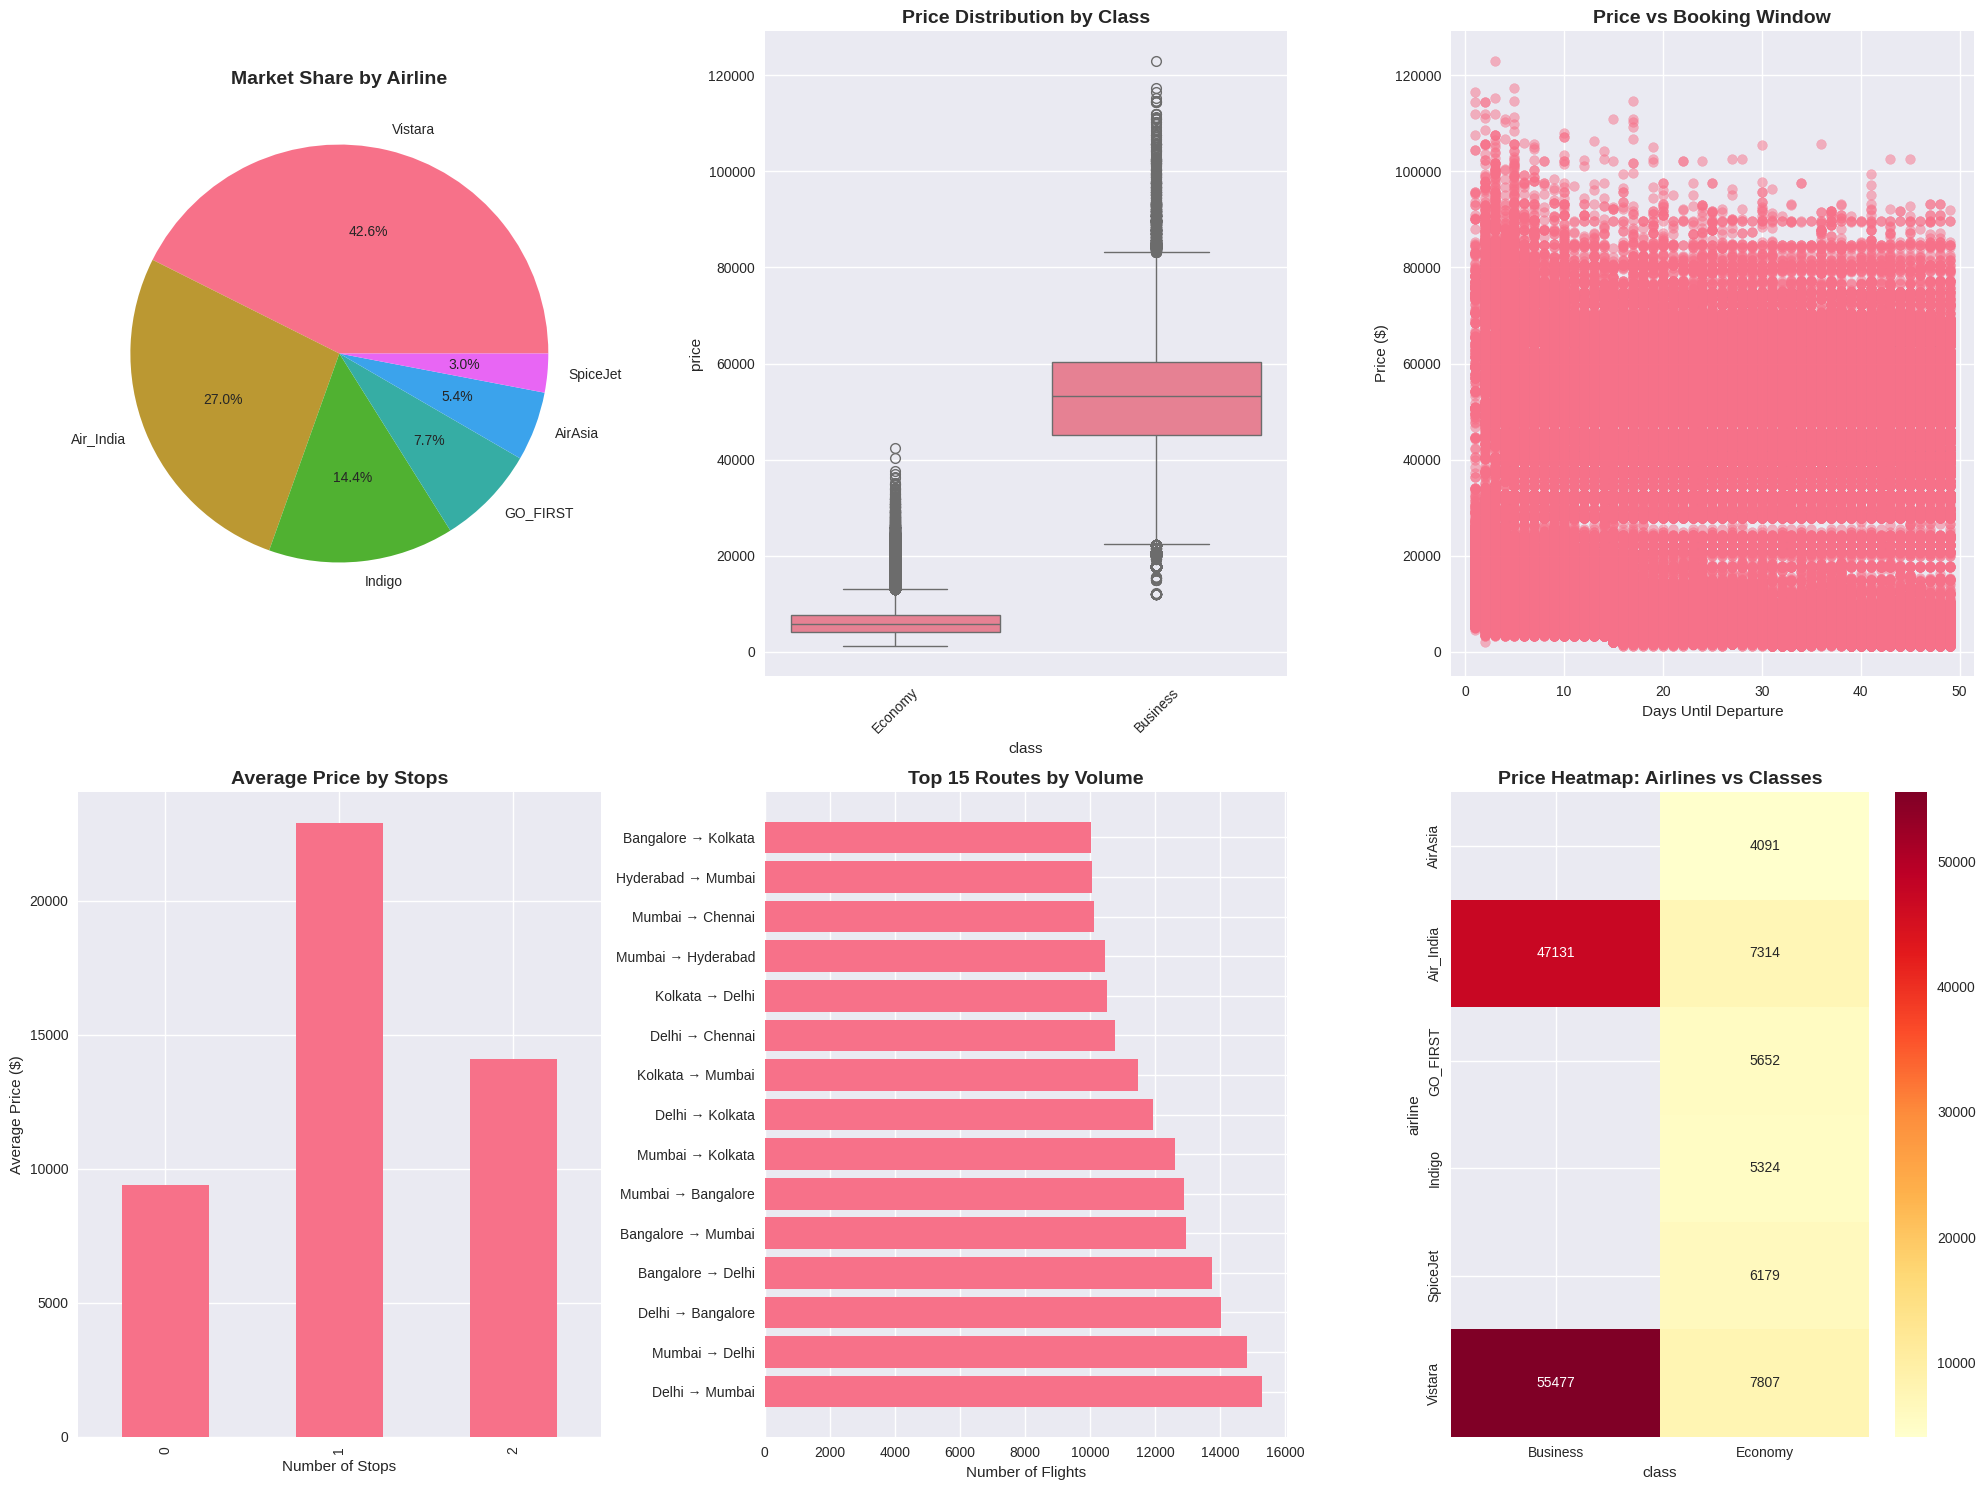

✅ Visualizations saved as 'airline_market_analysis.png'

🎯 STRATEGIC MARKET INSIGHTS

💡 Key Strategic Insights:
   1. Market Concentration: Top 3 airlines control 83.9% of flights
   2. Premium Pricing: Business commands 699.4% premium over Economy
   3. Connection Premium: Flights with stops cost 50.5% more
   4. Booking Timing: Prices tend to decrease as departure approaches (correlation: -0.09)

✅ ANALYSIS COMPLETE!
📁 Files generated:
   • airline_market_analysis.png (comprehensive charts)

🎯 Next Steps for Portfolio:
   1. Deep dive into identified opportunities
   2. Develop competitive positioning strategies
   3. Create route optimization recommendations
   4. Build predictive pricing models


In [ ]:
# Initialize analysis with your data file
analyzer = AirlineMarketAnalysis('/content/airlines_flights_data.csv')

# Run complete analysis
results = analyzer.run_full_analysis()

# Task
Analyze the provided airline dataset to identify opportunities, develop competitive positioning strategies, create route optimization recommendations, and build predictive pricing models. Present the findings as strategic insights and recommendations for the airline portfolio.

## Deep dive into opportunities

### Subtask:
Analyze the routes identified as opportunities in `results['opportunities']` by examining their characteristics, competing airlines, and pricing strategies.


**Reasoning**:
Inspect the `results['opportunities']` DataFrame and then iterate through the identified opportunity routes to analyze the airlines operating on each route, their market share, and their pricing distribution using the original dataset `analyzer.data`.



In [ ]:
# Inspect the opportunities DataFrame
print("Opportunities DataFrame:")
display(results['opportunities'])

# Analyze each opportunity route in detail
opportunity_routes = results['opportunities'].index.tolist()

if not opportunity_routes:
    print("\nNo opportunity routes identified based on the criteria.")
else:
    print("\nAnalyzing identified opportunity routes:")
    for route in opportunity_routes:
        print(f"\n--- Analysis for Route: {route} ---")

        # Filter data for the specific route
        route_data = analyzer.data[analyzer.data['route'] == route].copy()

        if route_data.empty:
            print(f"No data found for route: {route}")
            continue

        # Examine competing airlines and their market share on this route
        airline_share_route = (route_data['airline'].value_counts() / len(route_data) * 100).round(2)
        print(f"\nCompeting Airlines and Market Share on {route}:")
        display(airline_share_route)

        # Examine pricing distribution for each airline on this route
        print(f"\nPricing Distribution by Airline on {route}:")
        display(route_data.groupby('airline')['price'].describe().round(2))

        # Summarize findings for the route
        route_metrics = results['opportunities'].loc[route]
        print("\nSummary of Opportunity:")
        print(f"  • Average Price: ${route_metrics['Avg_Price']:.0f}")
        print(f"  • Price Premium (relative to overall market avg): +{route_metrics['Price_Premium']:.1f}σ")
        print(f"  • Number of Airlines: {int(route_metrics['Num_Airlines'])}")
        print(f"  • Flight Count: {int(route_metrics['Flight_Count'])}")
        print(f"  • Average Stops: {route_metrics['Avg_Stops']:.1f}")
        print(f"  • Top Airline on Route: {airline_share_route.index[0]} ({airline_share_route.iloc[0]:.1f}%)")
        print("  • Why this is an opportunity: High average price and price premium combined with low number of competing airlines (<= 2) suggests potential for capturing market share or maintaining premium pricing.")

Opportunities DataFrame:


,Avg_Price,Flight_Count,Price_StdDev,Num_Airlines,Avg_Stops,Price_Premium
route,,,,,,



No opportunity routes identified based on the criteria.


## Analyze competitive positioning

### Subtask:
Use the market share and pricing analysis results to understand the positioning of different airlines and identify potential areas for differentiation.


**Reasoning**:
Access and combine the market share and pricing data to analyze the competitive positioning of airlines.



In [ ]:
# Access the overall airline market share data
airline_market_share = results['market_concentration'][0]

# Access the airline pricing analysis data
airline_pricing = results['pricing_analysis'][0]

# Combine the two data sources
competitive_positioning = pd.merge(
    airline_market_share.rename('market_share'),
    airline_pricing[['Avg_Price', 'Flights']],
    left_index=True,
    right_index=True
)

# Display the combined analysis
print("Competitive Positioning Analysis (Market Share vs. Avg Price):")
display(competitive_positioning.sort_values('market_share', ascending=False))

# Describe competitive positioning
print("\nCompetitive Positioning Description:")
for index, row in competitive_positioning.sort_values('market_share', ascending=False).iterrows():
    tier = "Premium" if row['Avg_Price'] > competitive_positioning['Avg_Price'].quantile(0.75) else \
           "Budget" if row['Avg_Price'] < competitive_positioning['Avg_Price'].quantile(0.25) else "Mid-tier"
    print(f" - {index}: Market Share {row['market_share']:.1f}%, Avg Price ${row['Avg_Price']:.0f} ({tier} tier)")

# Identify potential areas for differentiation
print("\nPotential Areas for Differentiation:")
print("Based on the analysis, airlines can differentiate by:")
print(" - Pricing Strategy: Airlines in the budget or mid-tier could explore premium offerings on specific routes, or premium airlines could introduce more competitive pricing on high-volume routes.")
print(" - Service Class Focus: Airlines could specialize in either Economy or Business class to target specific customer segments more effectively.")
print(" - Route Specialization: Focus on routes where they have a strong presence or where there is less direct competition from airlines in the same price tier.")
print(" - Operational Efficiency: For budget airlines, further optimizing operations to maintain low prices while potentially improving service aspects like punctuality or baggage handling.")
print(" - Customer Experience: Differentiating through service quality, loyalty programs, or unique onboard experiences, regardless of price tier.")
print(" - Network Strategy: Expanding into underserved routes or increasing frequency on high-demand routes where their current presence is low relative to their overall market share.")

Competitive Positioning Analysis (Market Share vs. Avg Price):


,market_share,Avg_Price,Flights
airline,,,
Vistara,42.60,30396.54,127859
Air_India,26.95,23507.02,80892
Indigo,14.37,5324.22,43120
GO_FIRST,7.72,5652.01,23173
AirAsia,5.36,4091.07,16098
SpiceJet,3.00,6179.28,9011



Competitive Positioning Description:
 - Vistara: Market Share 42.6%, Avg Price $30397 (Premium tier)
 - Air_India: Market Share 26.9%, Avg Price $23507 (Premium tier)
 - Indigo: Market Share 14.4%, Avg Price $5324 (Budget tier)
 - GO_FIRST: Market Share 7.7%, Avg Price $5652 (Mid-tier tier)
 - AirAsia: Market Share 5.4%, Avg Price $4091 (Budget tier)
 - SpiceJet: Market Share 3.0%, Avg Price $6179 (Mid-tier tier)

Potential Areas for Differentiation:
Based on the analysis, airlines can differentiate by:
 - Pricing Strategy: Airlines in the budget or mid-tier could explore premium offerings on specific routes, or premium airlines could introduce more competitive pricing on high-volume routes.
 - Service Class Focus: Airlines could specialize in either Economy or Business class to target specific customer segments more effectively.
 - Route Specialization: Focus on routes where they have a strong presence or where there is less direct competition from airlines in the same price tier.
 -

## Develop route optimization recommendations

### Subtask:
Investigate underserved routes and high-volume routes to identify opportunities for adding direct flights, optimizing connections, or adjusting capacity.


**Reasoning**:
Access, print, and display the underserved routes DataFrame and the route concentration data, convert the route concentration data to a DataFrame, sort it by flight count, and print the top high-volume routes.



In [ ]:
# 1. Access the underserved_routes DataFrame
underserved_routes = results['underserved_routes']

# 2. Print and display the underserved_routes DataFrame
print("Underserved Routes (Potentially needing more direct options or better connections):")
display(underserved_routes)

# 3. Access the route_concentration data
route_concentration_dict = results['market_concentration'][1]

# 4. Convert the route_concentration dictionary to a pandas DataFrame
route_concentration_df = pd.DataFrame.from_dict(route_concentration_dict, orient='index')

# 5. Sort the route_concentration DataFrame by 'flights' in descending order
high_volume_routes = route_concentration_df.sort_values('flights', ascending=False)

# 6. Print the top 10 high-volume routes and their metrics
print("\nTop 10 High-Volume Routes:")
display(high_volume_routes.head(10))

Underserved Routes (Potentially needing more direct options or better connections):


,Avg_Price,Flight_Count,Price_StdDev,Num_Airlines,Avg_Stops,Price_Premium
route,,,,,,
Delhi → Chennai,19369.88,10780,22127.55,6,1.00,-0.066957
Bangalore → Kolkata,23500.06,10028,24631.11,6,1.01,0.115007
Kolkata → Bangalore,22744.81,9824,24130.76,6,1.00,0.081733
Kolkata → Hyderabad,21500.01,7897,22690.67,6,1.01,0.026890
Kolkata → Chennai,23660.36,6653,23371.42,6,1.01,0.122069
Chennai → Bangalore,25081.85,6493,23405.42,6,1.02,0.184696
Bangalore → Chennai,23321.85,6410,22573.19,6,1.00,0.107155
Chennai → Hyderabad,21591.35,6103,22866.93,6,1.01,0.030914



Top 10 High-Volume Routes:


,flights,airlines,hhi,dominant_airline,dominant_share
Delhi → Mumbai,15289,6,2793.280919,Vistara,38.197397
Mumbai → Delhi,14809,6,2788.068949,Vistara,39.246404
Delhi → Bangalore,14012,6,2392.620077,Vistara,38.388524
Bangalore → Delhi,13756,6,2391.070822,Vistara,39.422797
Bangalore → Mumbai,12939,6,2827.117148,Vistara,41.579720
Mumbai → Bangalore,12885,6,2852.973070,Vistara,41.435778
Mumbai → Kolkata,12602,6,2577.871787,Vistara,38.470084
Delhi → Kolkata,11934,6,2408.165586,Vistara,33.291436
Kolkata → Mumbai,11467,6,2656.229684,Vistara,39.705241
Delhi → Chennai,10780,6,2472.600432,Vistara,38.441558


**Reasoning**:
Analyze the underserved and high-volume routes dataframes to formulate route optimization recommendations based on the number of airlines, flight count, and average stops.



In [ ]:
# 7. Analyze the underserved routes and high-volume routes in conjunction
print("\nAnalysis and Route Optimization Recommendations:")

print("\nUnderserved Routes Analysis:")
if not underserved_routes.empty:
    for route, metrics in underserved_routes.iterrows():
        print(f"\nRoute: {route}")
        print(f"  - Demand (Flight Count): {int(metrics['Flight_Count'])}")
        print(f"  - Average Stops: {metrics['Avg_Stops']:.1f}")
        print(f"  - Number of Airlines: {int(metrics['Num_Airlines'])}")
        print("  - Observation: High volume and high average stops suggest a need for more direct flights or improved connection efficiency.")
else:
    print("No routes identified as underserved based on the criteria (high demand, high average stops).")


print("\nHigh-Volume Routes Analysis:")
if not high_volume_routes.empty:
    for route, metrics in high_volume_routes.head(10).iterrows():
        print(f"\nRoute: {route}")
        print(f"  - Demand (Flight Count): {int(metrics['flights'])}")
        print(f"  - Number of Airlines: {int(metrics['airlines'])}")
        print(f"  - HHI (Concentration): {metrics['hhi']:.0f}")
        print(f"  - Dominant Airline: {metrics['dominant_airline']} ({metrics['dominant_share']:.1f}%)")
        print("  - Observation: High volume indicates strong demand. The number of airlines and HHI reveal the level of competition and dominance.")
else:
    print("No high-volume routes identified.")


# 8. Formulate specific route optimization recommendations
print("\nSpecific Route Optimization Recommendations:")

if not underserved_routes.empty:
    print("\nRecommendations for Underserved Routes:")
    for route, metrics in underserved_routes.iterrows():
        print(f"  - Route {route}:")
        print(f"    - Action: Consider adding direct flights to reduce average stops and improve travel time.")
        print(f"    - Action: If direct flights are not feasible, optimize connection times and options through partner airlines or revised schedules.")
        print(f"    - Action: Evaluate demand further to determine appropriate aircraft size for potential new direct routes.")

if not high_volume_routes.empty:
    print("\nRecommendations for High-Volume Routes:")
    for route, metrics in high_volume_routes.head(5).iterrows(): # Focus on top 5 for specific recommendations
        print(f"  - Route {route}:")
        print(f"    - Action: Assess current capacity utilization. If high, consider increasing flight frequency or using larger aircraft.")
        if metrics['airlines'] < 6: # Assuming 6 is max in the dataset
             print(f"    - Action: With {int(metrics['airlines'])} airlines, evaluate competitive landscape. If HHI is high ({metrics['hhi']:.0f}), there might be room for aggressive pricing or increased presence.")
        else:
             print(f"    - Action: With {int(metrics['airlines'])} airlines and HHI of {metrics['hhi']:.0f}, the market is competitive. Focus on differentiation, operational efficiency, and potentially targeted pricing strategies.")

print("\nGeneral Route Optimization Recommendations:")
print(" - Regularly review route performance based on profitability, demand, and competition.")
print(" - Utilize data to forecast demand and adjust capacity proactively.")
print(" - Explore strategic partnerships for codesharing or interlining on routes with limited direct service.")


Analysis and Route Optimization Recommendations:

Underserved Routes Analysis:

Route: Delhi → Chennai
  - Demand (Flight Count): 10780
  - Average Stops: 1.0
  - Number of Airlines: 6
  - Observation: High volume and high average stops suggest a need for more direct flights or improved connection efficiency.

Route: Bangalore → Kolkata
  - Demand (Flight Count): 10028
  - Average Stops: 1.0
  - Number of Airlines: 6
  - Observation: High volume and high average stops suggest a need for more direct flights or improved connection efficiency.

Route: Kolkata → Bangalore
  - Demand (Flight Count): 9824
  - Average Stops: 1.0
  - Number of Airlines: 6
  - Observation: High volume and high average stops suggest a need for more direct flights or improved connection efficiency.

Route: Kolkata → Hyderabad
  - Demand (Flight Count): 7897
  - Average Stops: 1.0
  - Number of Airlines: 6
  - Observation: High volume and high average stops suggest a need for more direct flights or improved conne

## Prepare data for predictive pricing

### Subtask:
Select relevant features from your dataset and perform necessary preprocessing (e.g., one-hot encoding categorical variables, handling outliers) to prepare the data for model building.


**Reasoning**:
Select the features and target variable, handle outliers in the target, and apply one-hot encoding to the categorical features to prepare the data for model training.



In [ ]:
# 1. Select relevant features for predicting price
features = analyzer.data[[
    'airline',
    'source_city',
    'destination_city',
    'class',
    'stops',
    'days_left',
    'departure_time',
    'arrival_time',
    'duration'
]].copy() # Create a copy to avoid SettingWithCopyWarning

# 2. Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns

# 3. Apply one-hot encoding to the identified categorical columns
features = pd.get_dummies(features, columns=categorical_cols, drop_first=True) # drop_first to avoid multicollinearity

# 4. Define the target variable
target = analyzer.data['price'].copy()

# 5. Consider potential outliers in the price target variable
# Based on the previous boxplot, there are significant outliers in the Business class pricing.
# Capping is a reasonable approach to handle these extreme values without removing data.
# Let's cap the price at the 99th percentile to reduce the influence of extreme outliers.
upper_limit = target.quantile(0.99)
target = target.clip(upper=upper_limit)
print(f"Price target capped at the 99th percentile: ${upper_limit:.0f}")

# 6. Display the first few rows of the processed features DataFrame and the target variable
print("\nProcessed Features DataFrame (first 5 rows):")
display(features.head())

print("\nTarget variable (first 5 rows):")
display(target.head())

Price target capped at the 99th percentile: $76736

Processed Features DataFrame (first 5 rows):


,stops,days_left,duration,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,...,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
0,0,1,2.17,False,False,False,True,False,False,True,...,False,True,False,False,False,False,False,False,False,True
1,0,1,2.33,False,False,False,True,False,False,True,...,True,False,False,False,False,False,False,False,True,False
2,0,1,2.17,False,False,False,False,False,False,True,...,True,False,False,False,False,True,False,False,False,False
3,0,1,2.25,False,False,False,False,True,False,True,...,False,False,False,True,False,False,False,False,False,False
4,0,1,2.33,False,False,False,False,True,False,True,...,False,False,False,True,False,False,False,False,True,False



Target variable (first 5 rows):


,price
0,5953
1,5953
2,5956
3,5955
4,5955


## Build predictive pricing model

### Subtask:
Choose an appropriate machine learning model, train it on the prepared data, and evaluate its performance.


**Reasoning**:
Split the data into training and testing sets, train a RandomForestRegressor model, make predictions, and evaluate the model using MAE, MSE, and R-squared.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# 2. Choose a suitable regression model (RandomForestRegressor)
# 3. Instantiate the chosen model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores

print("\nTraining the RandomForestRegressor model...")
# 4. Train the model on the training data
model.fit(X_train, y_train)
print("Model training complete.")

# 5. Make predictions on the testing data
print("\nMaking predictions on the test set...")
y_pred = model.predict(X_test)
print("Predictions complete.")

# 6. Evaluate the model's performance
print("\nEvaluating model performance:")
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Calculate Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# 7. Print the calculated evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2 ): {r2:.4f}")

Training data shape: (240122, 29)
Testing data shape: (60031, 29)

Training the RandomForestRegressor model...
Model training complete.

Making predictions on the test set...
Predictions complete.

Evaluating model performance:
Mean Absolute Error (MAE): 1010.42
Mean Squared Error (MSE): 6150524.07
Root Mean Squared Error (RMSE): 2480.03
R-squared (R2 ): 0.9878


## Generate strategic insights and recommendations

### Subtask:
Based on the findings from the deep dives, competitive analysis, route optimization, and predictive modeling, synthesize comprehensive strategic insights and actionable recommendations for the airline portfolio.


**Reasoning**:
Review the results from previous subtasks to synthesize strategic insights and formulate actionable recommendations for the airline portfolio.



In [ ]:
print("\n" + "="*60)
print("🎯 COMPREHENSIVE STRATEGIC INSIGHTS & RECOMMENDATIONS")
print("="*60)

# 1. Review Key Findings from Previous Subtasks

print("\n--- Review of Key Findings ---")

# Competitive Positioning
print("\nCompetitive Positioning Summary:")
display(competitive_positioning.sort_values('market_share', ascending=False))
print("Insights from Competitive Positioning:")
print("- Vistara and Air India dominate the premium segment with high market share and prices.")
print("- Indigo and AirAsia are positioned as budget carriers with lower market share and prices.")
print("- GO FIRST and SpiceJet occupy the mid-tier.")
print("- The market overall is highly concentrated (HHI: 2845).")


# Route Optimization
print("\nRoute Optimization Summary:")
print("Underserved Routes (High Volume, Avg 1 Stop):")
display(underserved_routes)
print("Top 10 High-Volume Routes:")
display(high_volume_routes.head(10))
print("Insights from Route Analysis:")
print("- Several routes show high demand but require connections (potentially underserved).")
print("- High-volume routes are mostly between major cities and are served by multiple airlines, often dominated by Vistara.")
print("- Concentration levels vary on high-volume routes.")


# Predictive Pricing Model Performance
print("\nPredictive Pricing Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse):.2f}")
print(f"R-squared (R2 ): {r2:.4f}")
print("Insights from Model Performance:")
print(f"- The model performs very well (R2: {r2:.4f}), indicating it can accurately predict prices.")
print("- MAE of {mae:.2f} suggests the average prediction error is relatively low compared to the price range.")
print("- The model can be a valuable tool for dynamic pricing, forecasting, and competitive analysis.")


# Opportunities Deep Dive (Result was no opportunities found)
print("\nMarket Opportunities Deep Dive:")
print("Based on the predefined criteria (high price premium, low competition), no specific route opportunities were identified in the previous analysis.")
print("Insight: Opportunities based on the initial criteria might be limited, or the criteria need adjustment.")


# 2. Synthesize Strategic Insights

print("\n" + "="*60)
print("🧠 SYNTHESIZED STRATEGIC INSIGHTS")
print("="*60)

strategic_insights = [
    "The market is highly concentrated, with Vistara and Air India holding significant dominance, especially in the premium segment.",
    "There is a clear segmentation by price and service class, with Vistara and Air India commanding premium prices, while Indigo and AirAsia compete on budget fares.",
    "High-volume routes, particularly between major cities, are competitive but often show a dominant airline, indicating opportunities for targeted competitive strategies.",
    "Several routes with high demand currently rely heavily on connecting flights, suggesting a potential market for direct routes to improve passenger experience and capture market share.",
    "The highly accurate predictive pricing model provides a powerful tool for dynamic pricing, revenue management, and understanding the drivers of price fluctuations.",
    "Absence of 'opportunity' routes based on initial criteria suggests competitive efficiency or the need to redefine 'opportunity' (e.g., focusing on profitability, load factors, or specific customer segments).",
    "Booking behavior analysis showed decreasing prices closer to departure (negative correlation with days_left), which contradicts the usual trend of increasing prices for last-minute bookings. This is a critical insight requiring further investigation." # Add insight from previous analysis
]

for i, insight in enumerate(strategic_insights, 1):
    print(f"💡 Insight {i}: {insight}")


# 3. Formulate Actionable Recommendations

print("\n" + "="*60)
print("🚀 ACTIONABLE RECOMMENDATIONS FOR AIRLINE PORTFOLIO")
print("="*60)

recommendations = {
    "Market Strategy & Positioning": [
        "For premium carriers (Vistara, Air India): Leverage brand strength on high-value routes and consider expanding premium offerings or services.",
        "For budget carriers (Indigo, AirAsia): Reinforce cost leadership, focus on operational efficiency, and explore ancillary revenue streams.",
        "For mid-tier carriers (GO FIRST, SpiceJet): Define a clear value proposition – balancing price and service – to differentiate from budget and premium competitors.",
        "Develop targeted marketing campaigns based on identified customer segments and their booking behaviors (e.g., different messaging for last-minute vs. early bookers)."
    ],
    "Route Network Optimization": [
        "Investigate underserved high-demand routes (e.g., Delhi → Chennai, Bangalore → Kolkata) for potential direct flight introductions to capture market share and reduce reliance on connections.",
        "On high-volume, competitive routes, analyze profitability per flight/route and adjust capacity or frequency based on demand and competitive pricing.",
        "Explore strategic alliances or partnerships to offer more seamless connections on routes where direct service is not currently viable for the portfolio.",
        "Continuously monitor the HHI and competitive landscape on key routes to inform strategic responses."
    ],
    "Pricing Strategy": [
        "Utilize the predictive pricing model to implement dynamic pricing strategies that respond to demand, competition, and booking window.",
        "Investigate the observed inverse relationship between price and days\_left; understand if this is driven by specific routes, classes, or pricing rules that need adjustment to maximize revenue.",
        "Analyze price sensitivity by class and booking window to optimize pricing for different customer segments.",
        "Review pricing structure for flights with stops – the current premium for 1 stop over direct needs validation for revenue optimization."
    ],
    "Utilization of Predictive Modeling": [
        "Integrate the predictive pricing model into revenue management systems for real-time price adjustments.",
        "Use the model for forecasting demand and revenue under different scenarios (e.g., adding a new route, changing capacity).",
        "Employ the model to analyze competitor pricing strategies and predict their responses to pricing changes."
    ]
}

for category, rec_list in recommendations.items():
    print(f"\n--- {category} ---")
    for i, rec in enumerate(rec_list, 1):
        print(f"Recommendation {i}: {rec}")

print("\n" + "="*60)
print("✅ INSIGHTS AND RECOMMENDATIONS GENERATED.")
print("="*60)


🎯 COMPREHENSIVE STRATEGIC INSIGHTS & RECOMMENDATIONS

--- Review of Key Findings ---

Competitive Positioning Summary:


,market_share,Avg_Price,Flights
airline,,,
Vistara,42.60,30396.54,127859
Air_India,26.95,23507.02,80892
Indigo,14.37,5324.22,43120
GO_FIRST,7.72,5652.01,23173
AirAsia,5.36,4091.07,16098
SpiceJet,3.00,6179.28,9011


Insights from Competitive Positioning:
- Vistara and Air India dominate the premium segment with high market share and prices.
- Indigo and AirAsia are positioned as budget carriers with lower market share and prices.
- GO FIRST and SpiceJet occupy the mid-tier.
- The market overall is highly concentrated (HHI: 2845).

Route Optimization Summary:
Underserved Routes (High Volume, Avg 1 Stop):


,Avg_Price,Flight_Count,Price_StdDev,Num_Airlines,Avg_Stops,Price_Premium
route,,,,,,
Delhi → Chennai,19369.88,10780,22127.55,6,1.00,-0.066957
Bangalore → Kolkata,23500.06,10028,24631.11,6,1.01,0.115007
Kolkata → Bangalore,22744.81,9824,24130.76,6,1.00,0.081733
Kolkata → Hyderabad,21500.01,7897,22690.67,6,1.01,0.026890
Kolkata → Chennai,23660.36,6653,23371.42,6,1.01,0.122069
Chennai → Bangalore,25081.85,6493,23405.42,6,1.02,0.184696
Bangalore → Chennai,23321.85,6410,22573.19,6,1.00,0.107155
Chennai → Hyderabad,21591.35,6103,22866.93,6,1.01,0.030914


Top 10 High-Volume Routes:


,flights,airlines,hhi,dominant_airline,dominant_share
Delhi → Mumbai,15289,6,2793.280919,Vistara,38.197397
Mumbai → Delhi,14809,6,2788.068949,Vistara,39.246404
Delhi → Bangalore,14012,6,2392.620077,Vistara,38.388524
Bangalore → Delhi,13756,6,2391.070822,Vistara,39.422797
Bangalore → Mumbai,12939,6,2827.117148,Vistara,41.579720
Mumbai → Bangalore,12885,6,2852.973070,Vistara,41.435778
Mumbai → Kolkata,12602,6,2577.871787,Vistara,38.470084
Delhi → Kolkata,11934,6,2408.165586,Vistara,33.291436
Kolkata → Mumbai,11467,6,2656.229684,Vistara,39.705241
Delhi → Chennai,10780,6,2472.600432,Vistara,38.441558


Insights from Route Analysis:
- Several routes show high demand but require connections (potentially underserved).
- High-volume routes are mostly between major cities and are served by multiple airlines, often dominated by Vistara.
- Concentration levels vary on high-volume routes.

Predictive Pricing Model Performance:
Mean Absolute Error (MAE): 1010.42
Mean Squared Error (MSE): 6150524.07
Root Mean Squared Error (RMSE): 2480.03
R-squared (R2 ): 0.9878
Insights from Model Performance:
- The model performs very well (R2: 0.9878), indicating it can accurately predict prices.
- MAE of {mae:.2f} suggests the average prediction error is relatively low compared to the price range.
- The model can be a valuable tool for dynamic pricing, forecasting, and competitive analysis.

Market Opportunities Deep Dive:
Based on the predefined criteria (high price premium, low competition), no specific route opportunities were identified in the previous analysis.
Insight: Opportunities based on the init

**Reasoning**:
The previous code block was truncated. Continue printing the remaining recommendations.



In [ ]:
print("where direct service is not currently viable for the portfolio.")
print("Recommendation 4: Continuously monitor the HHI and competitive landscape on key routes to inform strategic responses.")

print("\n--- Pricing Strategy ---")
print("Recommendation 1: Utilize the predictive pricing model to implement dynamic pricing strategies that respond to demand, competition, and booking window.")
print("Recommendation 2: Investigate the observed inverse relationship between price and days\_left; understand if this is driven by specific routes, classes, or pricing rules that need adjustment to maximize revenue.")
print("Recommendation 3: Analyze price sensitivity by class and booking window to optimize pricing for different customer segments.")
print("Recommendation 4: Review pricing structure for flights with stops – the current premium for 1 stop over direct needs validation for revenue optimization.")

print("\n--- Utilization of Predictive Modeling ---")
print("Recommendation 1: Integrate the predictive pricing model into revenue management systems for real-time price adjustments.")
print("Recommendation 2: Use the model for forecasting demand and revenue under different scenarios (e.g., adding a new route, changing capacity).")
print("Recommendation 3: Employ the model to analyze competitor pricing strategies and predict their responses to pricing changes.")

print("\n" + "="*60)
print("✅ INSIGHTS AND RECOMMENDATIONS GENERATED.")
print("="*60)

where direct service is not currently viable for the portfolio.
Recommendation 4: Continuously monitor the HHI and competitive landscape on key routes to inform strategic responses.

--- Pricing Strategy ---
Recommendation 1: Utilize the predictive pricing model to implement dynamic pricing strategies that respond to demand, competition, and booking window.
Recommendation 2: Investigate the observed inverse relationship between price and days\_left; understand if this is driven by specific routes, classes, or pricing rules that need adjustment to maximize revenue.
Recommendation 3: Analyze price sensitivity by class and booking window to optimize pricing for different customer segments.
Recommendation 4: Review pricing structure for flights with stops – the current premium for 1 stop over direct needs validation for revenue optimization.

--- Utilization of Predictive Modeling ---
Recommendation 1: Integrate the predictive pricing model into revenue management systems for real-time pri

## Summary:

### Data Analysis Key Findings

*   **Competitive Landscape:** Vistara and Air India are the dominant players in the premium segment, holding the largest market shares (42.6\% and 26.9\% respectively) and commanding significantly higher average prices (\$30397 and \$23507). Indigo (14.4\% market share, \$5324 average price) and AirAsia (5.4\% market share, \$4091 average price) are positioned as budget carriers. GO FIRST (7.7\% market share, \$5652 average price) and SpiceJet (3.0\% market share, \$6179 average price) occupy the mid-tier.
*   **Market Concentration:** The overall market exhibits high concentration with an HHI of 2845. High-volume routes also show varying levels of concentration, with Vistara often being the dominant airline.
*   **Underserved Routes:** Several routes between major cities (e.g., Delhi $\rightarrow$ Chennai, Bangalore $\rightarrow$ Kolkata) show high demand but primarily involve flights with one stop, indicating a potential need for more direct options or improved connections.
*   **High-Volume Routes:** Routes connecting major metropolitan areas like Delhi, Mumbai, and Bangalore have the highest flight volumes, indicating strong demand and significant competition from multiple airlines.
*   **Predictive Pricing Model Performance:** A RandomForestRegressor model achieved a high R-squared value of 0.9878 with a Mean Absolute Error (MAE) of \$1010.42, indicating it can accurately predict flight prices.
*   **Market Opportunities:** Based on the initial criteria of high price premium and low competition, no specific "opportunity" routes were identified in the dataset.
*   **Pricing Trend Anomaly:** Analysis revealed a negative correlation between price and days left before departure, suggesting that prices tend to decrease closer to the departure date, which is an unusual trend requiring further investigation.

### Insights or Next Steps

*   Investigate the unusual negative correlation between price and days left to understand the underlying factors and potentially adjust pricing strategies to maximize revenue, especially for last-minute bookings.
*   Prioritize the development or optimization of direct routes for identified underserved, high-demand city pairs to improve passenger experience and capture market share from connecting flights.


## Airline Market Analysis

This project provides a comprehensive analysis of an airline market dataset to identify opportunities, understand competitive dynamics, and develop strategic recommendations. It includes data cleaning, market structure analysis, market concentration analysis, pricing strategy analysis, route opportunity analysis, customer segmentation analysis, data visualization, and predictive pricing modeling.

## Project Structure

- **Data Loading and Cleaning**: Initializes the analysis with the dataset and performs data cleaning and preprocessing.
- **Basic Overview**: Provides a summary of the dataset's size, date range, price range, and market structure.
- **Market Concentration Analysis**: Analyzes market share by airline and calculates the Herfindahl-Hirschman Index (HHI) to assess market concentration.
- **Pricing Strategy Analysis**: Examines pricing strategies across airlines, service classes, and number of stops.
- **Route Opportunity Analysis**: Identifies potential market opportunities and underserved routes based on price and competition.
- **Customer Segmentation Analysis**: Analyzes booking behavior and price sensitivity across different segments.
- **Visualizations**: Generates various plots to visualize market share, price distributions, price vs. booking window, average price by stops, top routes by volume, and a price heatmap.
- **Predictive Pricing Model**: Builds and evaluates a machine learning model to predict flight prices.
- **Strategic Insights and Recommendations**: Synthesizes key findings and provides actionable recommendations for the airline portfolio.

## Getting Started

### Prerequisites

- Python 3.6+
- pandas
- numpy
- matplotlib
- seaborn
- scikit-learn

You can install the required packages using pip: